# process the astrometry

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021

- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [146]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [147]:
from iminuit import Minuit
import iminuit

In [148]:
iminuit.__version__

'2.7.0'

In [149]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [150]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [151]:
from distutils.dir_util import copy_tree

In [152]:
# To view the output of the subprocess
import subprocess
from subprocess import Popen,PIPE, STDOUT, call

In [153]:
from astroquery.simbad import Simbad

In [154]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# Configuration

In [155]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [156]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [157]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [158]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    path_output_astrometry="astrometry"
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)
    path_output_astrometry="astrometry"

In [159]:
if not os.path.isdir(path_output_astrometry):
    os.mkdir(path_output_astrometry)

# Utility Functions

In [160]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [161]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [162]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [163]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [164]:
df=pd.read_csv(filename_logbook,index_col=0)

In [165]:
pd.set_option('display.max_rows', None)

In [166]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,1900.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [167]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [168]:
#idx=76
#idx=96
#idx=76 # start of narrow scan
idx=95

In [169]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000336_quickLookExp.fits


In [170]:
print(df.iloc[idx])

index                                                         95
date                                     2021-07-08T04:59:45.917
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000336_quick...
num                                                          336
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.079084
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.6
humidity                                                     6.0
windspd                  

In [171]:
myhome=os.getenv("HOME")

In [172]:
dir_images=path_images

In [173]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000336_quickLookExp.fits'

## target

In [174]:
target_name=file_target(filename_image)
target_name

'HD160617'

In [175]:
sky_coord_target=SkyCoord.from_name(target_name)
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (265.705515, -40.32097381)>

In [176]:
sky_coord_target.ra.deg

265.705515

In [177]:
file_astrometry="astrom_"+filename_image
fullfile_astrometry=os.path.join(path_output_astrometry,file_astrometry)

In [178]:
# Fullfilename
filename=os.path.join(dir_images,filename_image)

In [179]:
hdu = fits.open(filename)

In [180]:
hdu.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [181]:
# extract header and the image
header=hdu[0].header
image=hdu[1].data

In [182]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

In [183]:
hdu.close()

In [184]:
title="{}) {}".format(idx,filename_image)

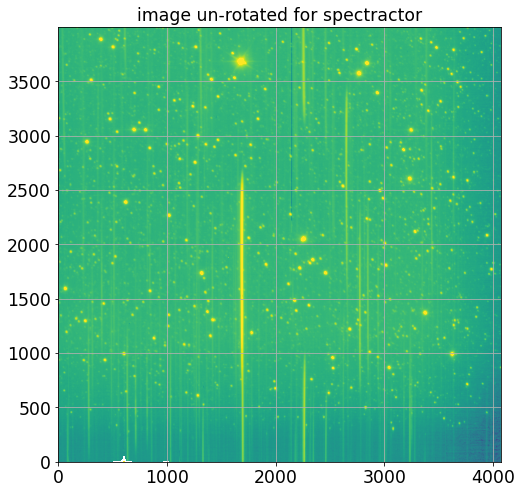

In [185]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
ax.set_title("image un-rotated for spectractor")
plt.show()

In [186]:
#del header["NAXIS"]                    
#del header["NAXIS1"]                                              
#del header["NAXIS2"]  

In [187]:
#header

In [188]:
hdu = fits.PrimaryHDU(image,header=header)

In [189]:
hdu.writeto(fullfile_astrometry,overwrite=True)

In [190]:
#cmd="/Users/dagoret/MacOSX/External/astrometry_net/bin/solve-field --scale-units arcsecperpix --scale-low 0.01 --scale-high 0.1 --ra 265.689 --dec -40.281 --radius 0.076 --overwrite "+fullfile_astrometry

In [191]:
cmd="/Users/dagoret/MacOSX/External/astrometry_net/bin/solve-field --scale-units arcsecperpix --scale-low 0.01 --scale-high 0.1 --ra {} --dec {} --radius 0.076 --overwrite {}".format(sky_coord_target.ra.deg,sky_coord_target.dec.deg,fullfile_astrometry)

In [192]:
cmd

'/Users/dagoret/MacOSX/External/astrometry_net/bin/solve-field --scale-units arcsecperpix --scale-low 0.01 --scale-high 0.1 --ra 265.705515 --dec -40.32097381 --radius 0.076 --overwrite astrometry/astrom_holo4_003_empty_HD160617_20210707_000336_quickLookExp.fits'

In [193]:
p   = Popen(cmd,shell=True,stdout=PIPE)
p.wait()
for line in p.stdout:
    #print(line.replace('\n', ''))
    print(line)



b'Reading input file 1 of 1: "astrometry/astrom_holo4_003_empty_HD160617_20210707_000336_quickLookExp.fits"...\n'
b'Found an existing WCS header, will try to verify it.\n'
b'Extracting sources...\n'
b'simplexy: found 2296 sources.\n'
b'Solving...\n'
b'Reading file "astrometry/astrom_holo4_003_empty_HD160617_20210707_000336_quickLookExp.axy"...\n'
b'Only searching for solutions within 0.076 degrees of RA,Dec (265.706,-40.321)\n'
b'Verifying WCS using indices with quads of size [2520, 25653.6] arcmin\n'
b'Got 0 solutions.\n'
b'Field 1 did not solve (index index-4204-42.fits, field objects 1-10).\n'
b'Field 1 did not solve (index index-4203-42.fits, field objects 1-10).\n'
b'Field 1 did not solve (index index-4202-42.fits, field objects 1-10).\n'
b'Field 1 did not solve (index index-4204-42.fits, field objects 11-20).\n'
b'Field 1 did not solve (index index-4203-42.fits, field objects 11-20).\n'
b'Field 1 did not solve (index index-4202-42.fits, field objects 11-20).\n'
b'Field 1 did not 